In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.integrate import solve_ivp
from scipy import sparse
from scipy.integrate import solve_bvp
from matplotlib.pyplot import figure
%matplotlib inline

import matplotlib.animation as animation

# Equations to Model

Tumors $\rightarrow$ Mass? or Num of cells

Breast cancer Gompertz model  $\rightarrow \frac{dT}{dt} = k_g*T*ln(\frac{T_{max}}{T})$

Create two functions:

1. Gompertz Model
2. Add a Treatment Function

## Homogenous Breast Cancer growth

In [8]:
def GompertzFE(t,k,Tmax,x0):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T)
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden 
        x0 (float): The initial condition
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    # Calculate U 
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j])
    return T

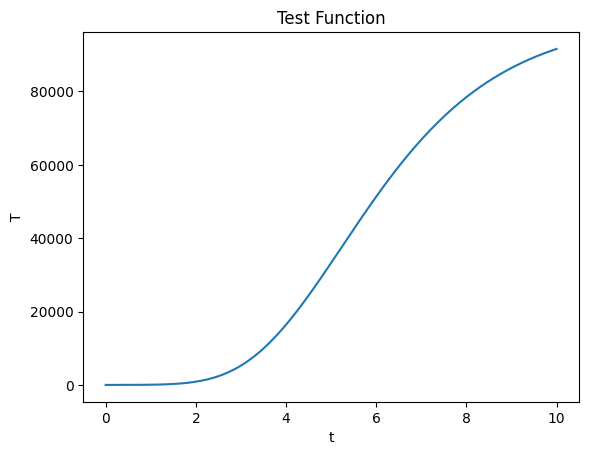

In [7]:
x0 = 1
k = .5
t = np.linspace(0,10,130)
Tmax = 100000
T = GompertzFE(t,k,Tmax,x0)
plt.plot(t,T)
plt.title('Test Function')
plt.xlabel('t')
plt.ylabel('T')
plt.show()

## Breast Cancer Treatment

In [9]:
def GompertzFEfunction(t,k,Tmax,x0,f):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T) + f
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden 
        x0 (float): The initial condition
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    # Calculate U 
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j]) + f(T[j])
    return T

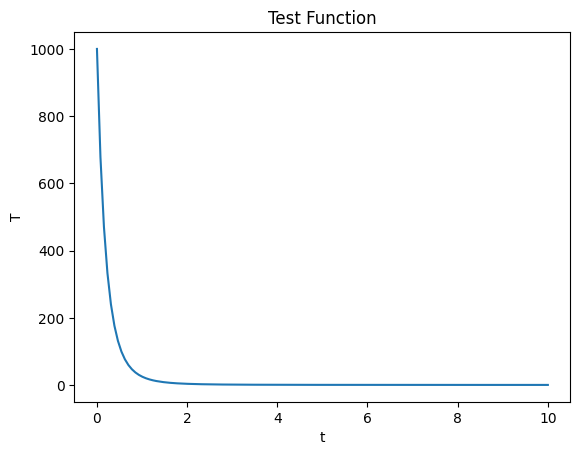

In [11]:
x0 = 1000
k = .5
t = np.linspace(0,10,130)
Tmax = 100000
f = lambda x: -.5*x
T = GompertzFEfunction(t,k,Tmax,x0, f)
plt.plot(t,T)
plt.title('Test Function')
plt.xlabel('t')
plt.ylabel('T')
plt.show()